In [5]:
import pandas as pd
import statistics
import seaborn as sns

<h2>Aims</h2>
<p>
    I recognised that the main challenge in evaluating the performance of any pricing model of the NFTs, would be coming up with a method that accounted for the varying price volatility amongst the assets. For this reason, I believe that the correct solution would have to incorporate a measure that adjusted for the price volatility, in order for the loss function's assessment to be uniformly valid across all of the NTFs. We can formally define the loss function I have used as follows.
</p>

<p>
    (actual_value - predicted_value)/V
</p>

<p>
    Where V is the rolling variance of the price deltas. The window size here is an adjustable hyperparameter set to 30 days by default.
</p>

<p>
    In order to quickly demonstrate the work of the loss function, the sparsity of the price data for each individual NFT was mitigated by allocating 'bucket' labels to the tokens based on their rarity score, and having the median daily price in each bucket represent its respective bucket. This allowed me to construct a timeseries of prices that would be broadly representative of a subset of the tokens (see variable named: timeser).
</p>


<h2>Model Tested</h2>
<p>
    I chose the rolling mean as an example of a trivial method with which to construct the model, however it is easily interchangable with a more robust timeseries evaluation method in the same context.
</p>

In [6]:
sales = pd.read_csv('data/cryptopunks/token_sales.csv')
metadata = pd.read_csv('data/cryptopunks/token_metadata.csv')

In [7]:
metadata['rarity_bucket'] = pd.cut(metadata['rarity_score'], 100)

In [8]:
buckets = sales.merge(metadata[['token_index','rarity_bucket']], on='token_index')
buckets['day'] = pd.to_datetime(buckets['timestamp'], unit='s').dt.floor('D')

In [9]:
buckets.groupby(['rarity_bucket','day']).agg({'eth':'median'}).dropna()

eth
rarity_bucket          day                 
(11.92, 125.4]         2017-06-23     0.075
                       2017-06-24     0.265
                       2017-06-25     0.150
                       2017-06-26     0.190
                       2017-06-27     0.200
...                                     ...
(2188.658, 2291.821]   2021-03-11  4200.000
                       2022-02-12  8000.000
(2291.821, 2394.984]   2021-03-11  4200.000
(10235.368, 10338.531] 2019-09-24    26.400
                       2020-05-20    85.000

[2544 rows x 1 columns]

In [10]:
common = buckets.loc[buckets['rarity_bucket'].astype('str').str.contains('\(125.4, 228.563]')]

In [11]:
timeser = common.groupby('day').agg({'eth':'median'})


<AxesSubplot: xlabel='day'>

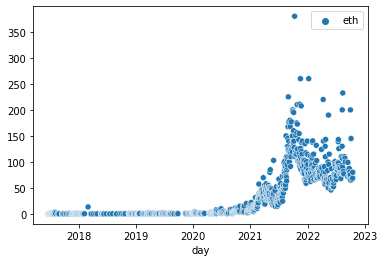

In [12]:
sns.scatterplot(timeser)

In [13]:
diffs = timeser.diff()
diffs.columns = ['delta']

<AxesSubplot: xlabel='day'>

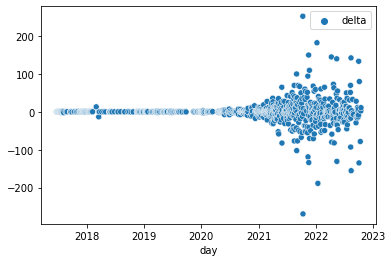

In [14]:
sns.scatterplot(diffs)

In [15]:
moving_avg = diffs.rolling(30).mean() #the window size was chosen arbitrarily

<AxesSubplot: xlabel='day'>

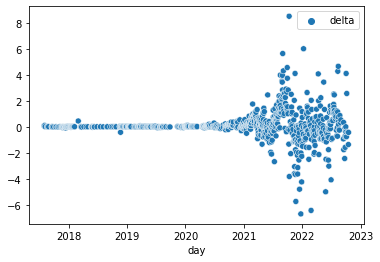

In [16]:
sns.scatterplot(moving_avg)

In [17]:
def loss_function(prediction, actual, volatility_window=30):
    return(actual - prediction)/actual.rolling(volatility_window).var()
    

In [18]:
model_results = pd.DataFrame()
model_results['diffs'] = diffs
model_results['moving_avg'] = moving_avg
model_results.dropna()
performance = loss_function(model_results['moving_avg'], model_results['diffs'])

<AxesSubplot: xlabel='day'>

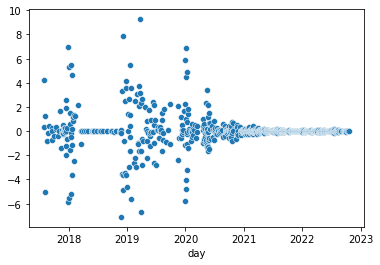

In [19]:
sns.scatterplot(performance)